This is an example notebook to classify physics signal versus background using the xgboost algorithm. we will use the same Higgs dataset used in the dense nn example.

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import uproot3 as uproot

In [3]:
signal = uproot.open("HIGGSsignal.root")['tree']

In [4]:
#df_signal = signal.pandas.df(['lep*','m*','je*'])
df_signal = signal.pandas.df(['m_*'])

In [5]:
df_signal

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
entry,,,,,,,
0,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
...,...,...,...,...,...,...,...
529668,0.948664,1.029377,1.052701,0.773623,0.318335,0.895034,0.838218
529669,0.905958,0.844373,0.985637,1.013631,0.937575,0.974468,0.829529
529670,0.607600,0.733236,1.187110,0.943022,0.315795,0.615857,0.772179


In [6]:
background = uproot.open("HIGGSbackground.root")['tree']

In [7]:
#df_background = background.pandas.df(['lep*','m*','je*'])
df_background = background.pandas.df(['m_*'])

In [8]:
df_signal=df_signal.assign(y=1)
df_background =df_background.assign(y=0)

In [9]:
df_list = [df_signal,df_background]

In [10]:
df = pd.concat(df_list)


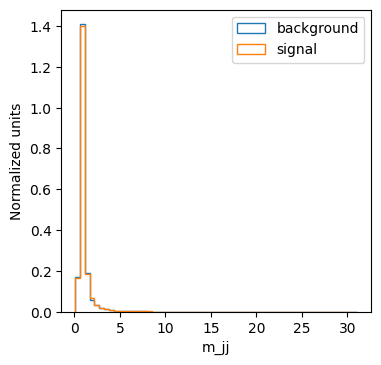

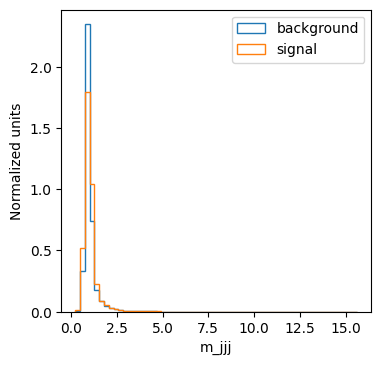

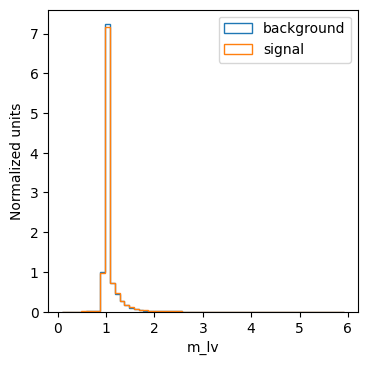

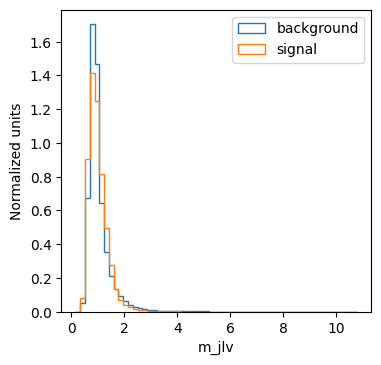

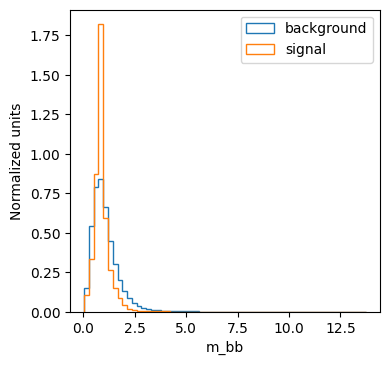

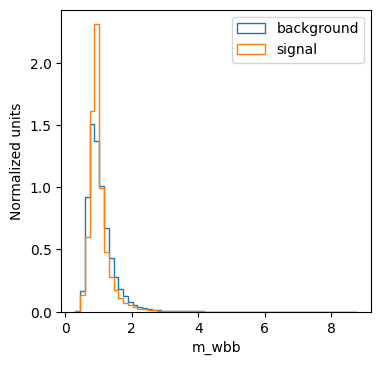

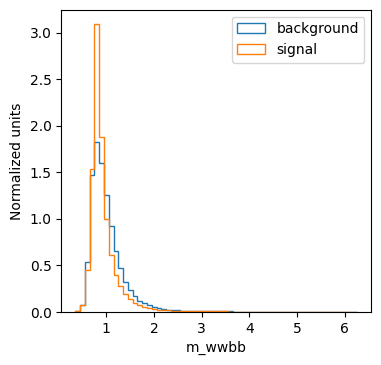

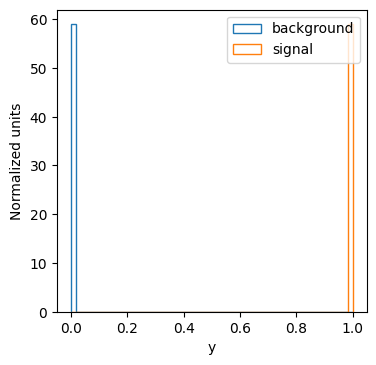

In [11]:
# iterate through the columns
for key in df.keys():
    # plotting settings
    #matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(4, 4), dpi=100)
    bins = np.linspace(min(df[key]), max(df[key]), 60)
    # plot!
    plt.hist(df[df.y<0.5][key], bins=bins, histtype='step',label='background',density=1)
    plt.hist(df[df.y>=0.5][key], bins=bins, histtype='step',label='signal',density=1)
    
    # decorate
    plt.xlabel(key)
    plt.ylabel('Normalized units')
    plt.legend()
    plt.plot()
    #plt.savefig("{}.png".format(key), bbox_inches="tight")

#### Let us plot the correlations b/w the input variables

Signal feature correlation matrix


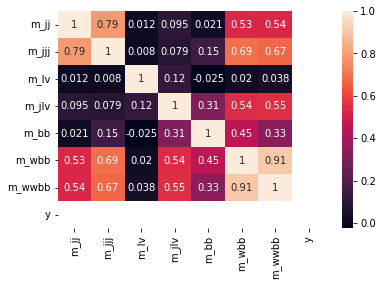

Background feature correlation matrix


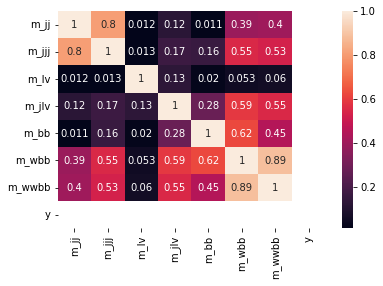

In [12]:
import seaborn as sn # seaborn for nice plot quicker
print ("Signal feature correlation matrix")
corrMatrix = df[df.y>0.5].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

print ("Background feature correlation matrix")
corrMatrix = df[df.y<0.5].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
dataset = df.values

In [14]:
X = dataset[:,0:7] # Load only high level features
y = dataset[:,7]

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train,X_test, y_train,y_test = train_test_split(X, y,
                                                  test_size=0.20, random_state=45)

Just like the dnn case, we will try 2 different models one based on a decision tree with no boosting and another using the xgboost algorithm

In [17]:
from sklearn import tree
model_simple = tree.DecisionTreeClassifier(max_depth=5)
model_simple = model_simple.fit(X_train, y_train)

In [18]:
print ('from test sample')
test_scores_simple = model_simple.predict_proba(X_test)

from test sample


In [19]:
train_scores_simple = model_simple.predict_proba(X_train)

In [20]:
from sklearn.metrics import roc_curve,auc

In [21]:
fpr_tr_simple, tpr_tr_simple, tresholds_tr_simple = roc_curve(y_train, train_scores_simple[:,1],pos_label=None, sample_weight=None)
fpr_te_simple, tpr_te_simple, tresholds_te_simple = roc_curve(y_test, test_scores_simple[:,1], pos_label=None, sample_weight=None)

In [22]:
test_auc_simple = auc(fpr_te_simple, tpr_te_simple)
print("BDT test set auc - {}".format(test_auc_simple))

BDT test set auc - 0.7186101548539543


Now we will try the same with xgboost algorithm

In [23]:
import xgboost as xgb

/home/sanu/anaconda3/envs/ml-latest/lib/python3.9/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [24]:
cls=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=50, missing=None, n_estimators=600, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1.2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

see https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn for the complete description of these parameters.


Also see https://towardsdatascience.com/de-mystifying-xgboost-part-i-f37c5e64ec8e and https://towardsdatascience.com/de-mystifying-xgboost-part-ii-175252dcdbc5 for more info on how xgboost actually works.


In [ ]:

cls.fit(X_train, y_train) #training

In [ ]:
print ('from train sample')
test_scores = cls.predict_proba(X_test)

train_scores = cls.predict_proba(X_train)

In [ ]:
from sklearn.metrics import roc_curve,auc

In [ ]:
fpr_tr, tpr_tr, tresholds_tr = roc_curve(y_train, train_scores[:,1],pos_label=None, sample_weight=None)
fpr_te, tpr_te, tresholds_te = roc_curve(y_test, test_scores[:,1], pos_label=None, sample_weight=None)

In [ ]:
train_auc = auc(fpr_tr, tpr_tr)
test_auc = auc(fpr_te, tpr_te)

In [ ]:
train_auc

In [ ]:
#ROC curve
fig, ax = plt.subplots(figsize=(5,5))
#ax.plot(tpr_tr, tpr_tr, lw=1, label='train (area - %0.3f)'%(train_auc))
ax.plot(tpr_tr, 1-fpr_tr, lw=1, label='train (area - %0.3f)'%(train_auc))
ax.plot(tpr_te, 1-fpr_te, lw=1, label='test (area - %0.3f)'%(test_auc))
ax.grid()
ax.legend(loc="lower right")
ax.set_ylim([0.0,1.0])
ax.set_xlim([0.0,1.0])
ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
fig.savefig("roc_xgb.png")

In [ ]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=20):
    decisions = []   
    for X,y in ((X_train, y_train), (X_test, y_test)):
         d1 = clf.predict_proba(X[y>0.5])[:, 1].ravel()
         d2 = clf.predict_proba(X[y<0.5])[:, 1].ravel()
         decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    plt.subplots(figsize=(6,6))
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=(0,1), bins=bins,
             histtype='step', density=1,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=(0,1), bins=bins,
             histtype='step', density=1,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=(0,1), density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='none', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=(0,1), density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='none', c='b', label='B (test)')
    
    plt.xlabel("XGB output")
    plt.ylabel("Normalized units")
    plt.legend(loc='best')
    plt.savefig("Xgboutput.png", bbox_inches="tight")

In [ ]:
compare_train_test(cls,X_train,y_train,X_test,y_test)

### Feature importance

In [ ]:
feature_names = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']

In [ ]:
from matplotlib import pyplot
# get importance
importance = cls.feature_importances_


In [ ]:
xgb_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
xgb_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("")
fig.tight_layout()

## HyperParameter tuning

In [ ]:
#import scipy.stats as stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [ ]:

#model = GradientBoostingRegressor()
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              ‘n_estimators’ :[50, 70, 100, 150], 
              
              'max_depth'    : sp_randInt(3, 5)
             }

In [ ]:

randm_src = RandomizedSearchCV(estimator=cls, param_distributions = parameters,
                           cv = 5, n_iter = 10, n_jobs=-1)
randm_src.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

### Exercize : Just like the dnn example, try to improve the current model by including more features, changing the hyperparmeters,regularization etc